In [1]:
#initializing packages
#%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('classic')
#import numpy as np
from pyDOE import lhs

from scipy.interpolate import griddata

from keras.models import Sequential
from keras.layers import Dense
from keras import initializers
import keras
import tensorflow as tf


Using TensorFlow backend.


In [30]:
def image_sample(X,Image):
    Y=np.zeros([X.shape[0],1])
    Nx = Image.shape[0]; Ny = Image.shape[1]
    dx = 1.0/(Nx-1); dy = 1.0/(Ny-1)
    ind_x = np.floor((X[:,0]/dx)).astype(int)
    ind_y = np.floor((X[:,1]/dy)).astype(int)
    
    x = (X[:,0]-dx*ind_x)/dx;
    y = (X[:,1]-dy*ind_y)/dy
    
    Y[:,0] = Image[ind_x,ind_y]*(1-x)*(1-y)
    
    my_ind=np.where(x>0)
    Y[my_ind,0] = Y[my_ind,0]+Image[ind_x[my_ind]+1,ind_y[my_ind]]*(x[my_ind])*(1-y[my_ind])
    my_ind=np.where(y>0)
    Y[my_ind,0] = Y[my_ind,0]+Image[ind_x[my_ind],ind_y[my_ind]+1]*(1-x[my_ind])*(y[my_ind])

    my_ind=np.logical_and(y>0,x>0)
    Y[my_ind,0] = Y[my_ind,0]+Image[ind_x[my_ind]+1,ind_y[my_ind]+1]*(x[my_ind])*(y[my_ind])

    return  Y
    

In [31]:
tmin, tmax = 0.0, 1.0; xmin, xmax = 0.0, 1.0 # Domain bounds

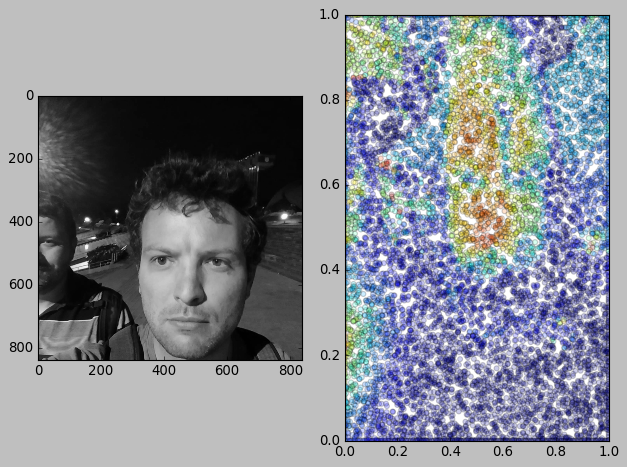

In [32]:
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from scipy import interpolate
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt

face = io.imread('face3.png')

ii=np.arange(0,face.shape[1])
face=face[ii+90,:]#+1e-3

face=np.mean(face[:,:,0:3],axis=2)
face=(face-face.mean())/(np.std(face))
#face2  = rescale(face, 0.25, anti_aliasing=False)
#face3  = rescale(face, 0.25, anti_aliasing=True)
face4  = downscale_local_mean(face, (4,4))
face5  = resize(face, [837,837])

dd=face5

Nb = 200
Xb = np.zeros([Nb*4,2])
Yb = np.zeros([Nb*4,1])

Xb[0:Nb,1] = lhs(1,Nb)[:,0]
Xb[0:Nb,0] = 0
Xb[Nb:2*Nb,1] = 0
Xb[Nb:2*Nb,0] = lhs(1,Nb)[:,0]
Xb[2*Nb:3*Nb,1] = lhs(1,Nb)[:,0]
Xb[2*Nb:3*Nb,0] = 1
Xb[3*Nb:4*Nb,1] = 1
Xb[3*Nb:4*Nb,0] = lhs(1,Nb)[:,0]

Yb = image_sample(Xb,dd.T)

Nf = 10000
#Nb = 
Xf = np.zeros([Nf,2])
Yf = np.zeros([Nf,1])
Xf = lhs(2,Nf)

Yf=image_sample(Xf,dd.T)

Xall = np.vstack([Xb,Xf])
Yall = np.vstack([Yb,Yf])

Xall=Xall*2-1
ind=np.arange(0,len(Xall))
np.random.shuffle(ind)
Xall=Xall[ind]
Yall=Yall[ind]
#Yf=face_interp(Xf[:,0],Xf[:,1])

plt.figure(0);plt.clf()
plt.subplot(1,2,1)
plt.imshow(dd,cmap='gray')
plt.subplot(1,2,2)
plt.scatter(Xb[:,0],Xb[:,1],c=Yb[:,0],cmap='jet',alpha=0.2,marker='o')
plt.scatter(Xf[:,0],Xf[:,1],c=Yf[:,0],cmap='jet',alpha=0.2,marker='o')
plt.xlim(0,1);plt.ylim(0,1)
#plt.scatter(Xf[:,1],Xf[:,0],c=Yf[0,:],cmap='gray',alpha=0.1)


plt.tight_layout()

In [33]:
#myActiv='relu'
myActiv='elu'

#myActiv='softplus'
#myActiv='selu'
myNumInner=20
myWinner=15

#myInit=initializers.Orthogonal(gain=1.0, seed=None)
myInit=initializers.he_uniform(seed=None)
#myInit=initializers.he_normal(seed=None)
#myInit="normal"#initializers.he_normal(seed=None)

#myInit=initializers.lecun_normal(seed=None)
#myInit=initializers.glorot_normal(seed=None)
# define the keras model
model = Sequential()
model.add(Dense(myWinner, input_dim=2, activation='linear',kernel_initializer=myInit))

for jj in range(0, myNumInner):
    model.add(Dense(myWinner, activation=myActiv,kernel_initializer=myInit))

    #model.add(BatchNormalization())
    
model.add(Dense(1, activation='linear',kernel_initializer=myInit))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 15)                45        
_________________________________________________________________
dense_46 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_47 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_48 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_49 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_50 (Dense)             (None, 15)                240       
_________________________________________________________________
dense_51 (Dense)             (None, 15)               

In [36]:
for jj in range(0, len(model.layers)):
    model.layers[jj].trainable=True

In [37]:
start_layer=10
for jj in range(1, myNumInner+1):
    
    if(jj<=start_layer):
         model.layers[jj].trainable=False

In [38]:
odd = 0
for jj in range(1, myNumInner+1):
    if((jj+odd)%2==0):
        print(jj)
        model.layers[jj].trainable=False

2
4
6
8
10
12
14
16
18
20


In [39]:
from keras import optimizers
myLR=0.001
my_optimizer=optimizers.Adam(lr=myLR, beta_1=0.9, beta_2=0.999, amsgrad=False)
loss = tf.keras.losses.Huber(delta=1.0)
#loss = tf.keras.losses.mean_squared_logarithmic_error()
##my_optimizer=optimizers.Adadelta(lr=1.0, rho=0.95)
#my_optimizer=optimizers.SGD(lr=0.01, momentum=0.1, nesterov=False)
#model.compile(loss='mse', optimizer=my_optimizer, metrics=['accuracy'])
#model.compile(loss='logcosh', optimizer=my_optimizer, metrics=['accuracy'])
#loss='mean_squared_logarithmic_error'
#loss='mean_absolute_percentage_error'
model.compile(loss=loss, optimizer=my_optimizer, metrics=['accuracy'])

#model.compile(loss='mae', optimizer=my_optimizer, metrics=['accuracy'])

In [40]:
## fit the keras model on the dataset
model.fit(Xall, Yall, epochs=1000, batch_size=int(len(Xall/2)),shuffle=False)
#model.fit(Xall, Yall, epochs=1000, batch_size=1000,shuffle=True)

Epoch 1/1000
10800/10800 [==============================] - 1s 56us/step - loss: 2.5136 - accuracy: 0.0000e+00
Epoch 2/1000
10800/10800 [==============================] - 0s 4us/step - loss: 2.2464 - accuracy: 0.0000e+00
Epoch 3/1000
10800/10800 [==============================] - 0s 3us/step - loss: 1.9619 - accuracy: 0.0000e+00
Epoch 4/1000
10800/10800 [==============================] - 0s 2us/step - loss: 1.6928 - accuracy: 0.0000e+00
Epoch 5/1000
10800/10800 [==============================] - 0s 3us/step - loss: 1.4548 - accuracy: 0.0000e+00
Epoch 6/1000
10800/10800 [==============================] - 0s 2us/step - loss: 1.2524 - accuracy: 0.0000e+00
Epoch 7/1000
10800/10800 [==============================] - 0s 3us/step - loss: 1.0803 - accuracy: 0.0000e+00
Epoch 8/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.9333 - accuracy: 0.0000e+00
Epoch 9/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.8092 - accuracy: 0.0000e+00
Epoch 10/

Epoch 75/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.2261 - accuracy: 0.0000e+00
Epoch 76/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.2250 - accuracy: 0.0000e+00
Epoch 77/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.2239 - accuracy: 0.0000e+00
Epoch 78/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.2228 - accuracy: 0.0000e+00
Epoch 79/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.2217 - accuracy: 0.0000e+00
Epoch 80/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.2206 - accuracy: 0.0000e+00
Epoch 81/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.2194 - accuracy: 0.0000e+00
Epoch 82/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.2182 - accuracy: 0.0000e+00
Epoch 83/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.2170 - accuracy: 0.0000e+00
E

Epoch 149/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1597 - accuracy: 0.0000e+00
Epoch 150/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1592 - accuracy: 0.0000e+00
Epoch 151/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1588 - accuracy: 0.0000e+00
Epoch 152/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1583 - accuracy: 0.0000e+00
Epoch 153/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1579 - accuracy: 0.0000e+00
Epoch 154/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1574 - accuracy: 0.0000e+00
Epoch 155/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1570 - accuracy: 0.0000e+00
Epoch 156/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.1566 - accuracy: 0.0000e+00
Epoch 157/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.1562 - accuracy: 0.0

Epoch 223/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1384 - accuracy: 0.0000e+00
Epoch 224/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1382 - accuracy: 0.0000e+00
Epoch 225/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1380 - accuracy: 0.0000e+00
Epoch 226/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1378 - accuracy: 0.0000e+00
Epoch 227/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1376 - accuracy: 0.0000e+00
Epoch 228/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1374 - accuracy: 0.0000e+00
Epoch 229/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1372 - accuracy: 0.0000e+00
Epoch 230/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1370 - accuracy: 0.0000e+00
Epoch 231/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1369 - accuracy: 0.0

Epoch 297/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1270 - accuracy: 0.0000e+00
Epoch 298/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1269 - accuracy: 0.0000e+00
Epoch 299/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1268 - accuracy: 0.0000e+00
Epoch 300/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1267 - accuracy: 0.0000e+00
Epoch 301/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1266 - accuracy: 0.0000e+00
Epoch 302/1000
10800/10800 [==============================] - 0s 1us/step - loss: 0.1265 - accuracy: 0.0000e+00
Epoch 303/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.1264 - accuracy: 0.0000e+00
Epoch 304/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1263 - accuracy: 0.0000e+00
Epoch 305/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1262 - accuracy: 0.0

Epoch 371/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1202 - accuracy: 0.0000e+00
Epoch 372/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1202 - accuracy: 0.0000e+00
Epoch 373/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1201 - accuracy: 0.0000e+00
Epoch 374/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1200 - accuracy: 0.0000e+00
Epoch 375/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1199 - accuracy: 0.0000e+00
Epoch 376/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1198 - accuracy: 0.0000e+00
Epoch 377/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1198 - accuracy: 0.0000e+00
Epoch 378/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1197 - accuracy: 0.0000e+00
Epoch 379/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1196 - accuracy: 0.0

Epoch 445/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.1143 - accuracy: 0.0000e+00
Epoch 446/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.1143 - accuracy: 0.0000e+00
Epoch 447/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1142 - accuracy: 0.0000e+00
Epoch 448/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1141 - accuracy: 0.0000e+00
Epoch 449/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1140 - accuracy: 0.0000e+00
Epoch 450/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1139 - accuracy: 0.0000e+00
Epoch 451/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1138 - accuracy: 0.0000e+00
Epoch 452/1000
10800/10800 [==============================] - 0s 2us/step - loss: 0.1137 - accuracy: 0.0000e+00
Epoch 453/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.1137 - accuracy: 0.0

Epoch 519/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1073 - accuracy: 0.0000e+00
Epoch 520/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.1072 - accuracy: 0.0000e+00
Epoch 521/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1072 - accuracy: 0.0000e+00
Epoch 522/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1071 - accuracy: 0.0000e+00
Epoch 523/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.1070 - accuracy: 0.0000e+00
Epoch 524/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1069 - accuracy: 0.0000e+00
Epoch 525/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1068 - accuracy: 0.0000e+00
Epoch 526/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1067 - accuracy: 0.0000e+00
Epoch 527/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.1067 - accuracy: 0.0

Epoch 666/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.0947 - accuracy: 0.0000e+00
Epoch 667/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0947 - accuracy: 0.0000e+00
Epoch 668/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0946 - accuracy: 0.0000e+00
Epoch 669/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0945 - accuracy: 0.0000e+00
Epoch 670/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.0944 - accuracy: 0.0000e+00
Epoch 671/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0944 - accuracy: 0.0000e+00
Epoch 672/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0943 - accuracy: 0.0000e+00
Epoch 673/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0942 - accuracy: 0.0000e+00
Epoch 674/1000
10800/10800 [==============================] - 0s 5us/step - loss: 0.0941 - accuracy: 0.0

Epoch 740/1000
10800/10800 [==============================] - 0s 5us/step - loss: 0.0907 - accuracy: 0.0000e+00
Epoch 741/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0907 - accuracy: 0.0000e+00
Epoch 742/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0907 - accuracy: 0.0000e+00
Epoch 743/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0906 - accuracy: 0.0000e+00
Epoch 744/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0906 - accuracy: 0.0000e+00
Epoch 745/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0905 - accuracy: 0.0000e+00
Epoch 746/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.0905 - accuracy: 0.0000e+00
Epoch 747/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0905 - accuracy: 0.0000e+00
Epoch 748/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0904 - accuracy: 0.0

Epoch 814/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0882 - accuracy: 0.0000e+00
Epoch 815/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0881 - accuracy: 0.0000e+00
Epoch 816/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0881 - accuracy: 0.0000e+00
Epoch 817/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0880 - accuracy: 0.0000e+00
Epoch 818/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0880 - accuracy: 0.0000e+00
Epoch 819/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0880 - accuracy: 0.0000e+00
Epoch 820/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0879 - accuracy: 0.0000e+00
Epoch 821/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0879 - accuracy: 0.0000e+00
Epoch 822/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0879 - accuracy: 0.0

Epoch 888/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0851 - accuracy: 0.0000e+00
Epoch 889/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0850 - accuracy: 0.0000e+00
Epoch 890/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0850 - accuracy: 0.0000e+00
Epoch 891/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0850 - accuracy: 0.0000e+00
Epoch 892/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0849 - accuracy: 0.0000e+00
Epoch 893/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0849 - accuracy: 0.0000e+00
Epoch 894/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0848 - accuracy: 0.0000e+00
Epoch 895/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0848 - accuracy: 0.0000e+00
Epoch 896/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0848 - accuracy: 0.0

Epoch 962/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.0826 - accuracy: 0.0000e+00
Epoch 963/1000
10800/10800 [==============================] - 0s 4us/step - loss: 0.0826 - accuracy: 0.0000e+00
Epoch 964/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0825 - accuracy: 0.0000e+00
Epoch 965/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0825 - accuracy: 0.0000e+00
Epoch 966/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0825 - accuracy: 0.0000e+00
Epoch 967/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0825 - accuracy: 0.0000e+00
Epoch 968/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0824 - accuracy: 0.0000e+00
Epoch 969/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0824 - accuracy: 0.0000e+00
Epoch 970/1000
10800/10800 [==============================] - 0s 3us/step - loss: 0.0824 - accuracy: 0.0

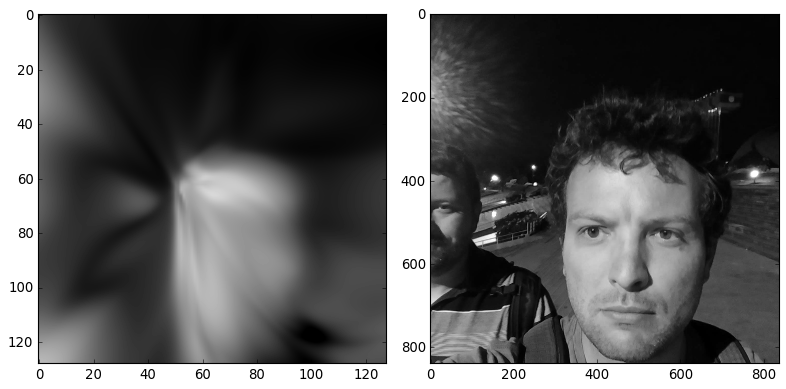

In [41]:
numnum=128

xrange=2*np.array([xmin,xmax])-1
trange=2*np.array([tmin,tmax])-1

xx=np.linspace(xrange[0],xrange[1],numnum)
tt=np.linspace(trange[0],trange[1],numnum)

T,X = np.meshgrid(tt,xx)
X_star = np.hstack((T.flatten()[:,None],X.flatten()[:,None]))

Y_star = model.predict(X_star)

Y1=griddata(X_star, Y_star.flatten(), (T,X), method='cubic')

plt.figure(13,facecolor='none',figsize=(10,6));plt.clf()

plo=Y1.T
plt.subplot(1,2,1)
levels=np.linspace(plo.min(),plo.max(),251)

plt.imshow(plo.T,cmap='gray')
plt.clim(np.min(Yall),np.max(Yall))

plt.subplot(1,2,2)

plt.imshow(dd,cmap='gray')
plt.clim(np.min(Yall),np.max(Yall))

plt.tight_layout()

In [42]:
model.save("face")

In [43]:
from tensorflow.python.client import device_lib

from keras import backend as K

K.tensorflow_backend._get_available_gpus()

[]

In [44]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13626573522970179956
]
